# Exercise 1

In [644]:
# import packages
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
import scipy.integrate as integrate
import time
from numba import jit
import scipy.optimize as opt

#set up the parameters
sizez = 9
rho = 0.7605
mu = 0.0
sigma_eps = 0.213
sigma_z = sigma_eps / ((1 - rho ** 2) ** (1 / 2))
alpha_k = 0.297
alpha_l = 0.65
delta = 0.154
psi = 1.08
w = 0.7
r= 0.04
z = 1
psi1 = 0.03
betafirm = (1 / (1 + r))

# to print plots inline
%matplotlib inline


# Compute cut-off values
N = sizez  # number of grid points (will have one more cut-off point than this)
z_cutoffs = (sigma_z * norm.ppf(np.arange(N + 1) / N)) + mu
print('Cut-off values = ', z_cutoffs)
# compute grid points for z
z_grid = ((N * sigma_z * (norm.pdf((z_cutoffs[:-1] - mu) / sigma_z)
                              - norm.pdf((z_cutoffs[1:] - mu) / sigma_z)))
              + mu)
print('Grid points = ', z_grid)


# define function that we will integrate
def integrand(x, sigma_z, sigma_eps, rho, mu, z_j, z_jp1):
    val = (np.exp((-1 * ((x - mu) ** 2)) / (2 * (sigma_z ** 2)))
            * (norm.cdf((z_jp1 - (mu * (1 - rho)) - (rho * x)) / sigma_eps)
               - norm.cdf((z_j - (mu * (1 - rho)) - (rho * x)) / sigma_eps)))
    
    return val

# compute transition probabilities
pi = np.empty((N, N))
for i in range(N):
    for j in range(N):
        results = integrate.quad(integrand, z_cutoffs[i], z_cutoffs[i + 1],
                                 args = (sigma_z, sigma_eps, rho, mu,
                                         z_cutoffs[j], z_cutoffs[j + 1]))
        pi[i,j] = (N / np.sqrt(2 * np.pi * sigma_z ** 2)) * results[0]

Cut-off values =  [       -inf -0.40040229 -0.25084498 -0.14128994 -0.04582867  0.04582867
  0.14128994  0.25084498  0.40040229         inf]
Grid points =  [-0.55913938 -0.32004072 -0.19425291 -0.09290094  0.          0.09290094
  0.19425291  0.32004072  0.55913938]


In [622]:
dens = 5
z_grid = np.exp(z_grid)
# put in bounds here for the capital stock space
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (z ** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 2*kstar
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
for j in range(int(numb * dens)):
    K[j] = ub_k * (1 - delta) ** (j / dens)
kvec = K[::-1]
sizek = kvec.shape[0]

In [623]:
# operating profits, op
op = np.zeros((sizek, sizez))
for i in range(sizez):
    z = z_grid[i]
    op[:, i] = ((1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) *
      ((kvec ** alpha_k) ** (1 / (1 - alpha_l)))) * z ** (1/ (1 - alpha_l))

# firm cash flow, e
e = np.zeros((sizez, sizek, sizek))
for k in range(sizez):
    for i in range(sizek):
        for j in range(sizek):
                e[k, i, j] = (op[i, k] - kvec[j] + ((1 - delta) * kvec[i]) -
                           ((psi / 2) * ((kvec[j] - ((1 - delta) * kvec[i])) ** 2)
                            / kvec[i]))

In [624]:
#notice that the cash flow with the dimension (z, k, k')
VFtol = 1e-6
VFdist = 7.0
VFmaxiter = 3000
V = np.zeros((sizek, sizez))  # initial guess at value function
Vmat = np.zeros((sizez, sizek, sizek))  # initialize Vmat matrix
Vstore = np.zeros((VFmaxiter, sizez, sizek))  # initialize Vstore array
VFiter = 1
start_time = time.clock()

In [625]:
def it_grid(sizez, sizek, Vmat, V, e):
    for k in range(sizez): #loope over different productivity
        for i in range(sizek):  # loop over k
            for j in range(sizek):  # loop over k'
                Vmat[k, i, j] = e[k, i, j] + betafirm * pi[k,:] @ V[j, :]
    return Vmat

it_grid_nb = jit(it_grid)
    
PF = np.zeros((sizez, sizek))
while VFdist > VFtol and VFiter < VFmaxiter:
    TV = V.copy()
#     for k in range(sizez): #loope over different productivity
#         for i in range(sizek):  # loop over k
#             for j in range(sizek):  # loop over k'
#                 Vmat[k, i, j] = e[k, i, j] + betafirm * pi[k,:] @ V[j, :]
    Vmat = it_grid_nb(sizez, sizek, Vmat, V, e)
    Vstore[VFiter, :, :] = V.T  # store value function at each
    # iteration for graphing later
    for k in range(sizez):
        V[:, k] = Vmat[k, :, :].max(axis=1)  # apply max operator to Vmat (to get V(k))
        PF[k, :] = np.argmax(Vmat[k, :, :], axis=1)  # find the index of the optimal k'
    VFdist = (np.absolute(V - TV)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    if VFiter % 10 == 0 or VFiter == 1:
        print(VFiter, VFdist)
    VFiter += 1

VFI_time = time.clock() - start_time
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')
print('VFI took ', VFI_time, ' seconds to solve')

1 19.8131898031
10 1.49537734865
20 0.746165464535
30 0.490131214297
40 0.330518740597
50 0.223263807163
60 0.150828205356
70 0.101894102535
80 0.0688360037132
90 0.0465031376012
100 0.0314158535003
110 0.0212234249578
120 0.0143377854413
130 0.00968609410444
140 0.00654357811285
150 0.00442060690895
160 0.00298640363216
170 0.00201750728755
180 0.00136295563382
190 0.00092076398991
200 0.000622035159537
210 0.000420224665532
220 0.000283888726912
230 0.000191785051825
240 0.000129563109141
250 8.75281941433e-05
260 5.91309117226e-05
270 3.99467252379e-05
280 2.69865762448e-05
290 1.82311639492e-05
300 1.23163211256e-05
310 8.32046524835e-06
320 5.62100819224e-06
330 3.79735173794e-06
340 2.56535477661e-06
350 1.73306177231e-06
360 1.17079444095e-06
Value function converged after this many iterations: 366
VFI took  44.52324200000021  seconds to solve


In [626]:
PF = PF.astype(int)

In [627]:
VF = V  # solution to the functional equation
'''
------------------------------------------------------------------------
Find optimal capital and investment policy functions
------------------------------------------------------------------------
optK = (sizek,) vector, optimal choice of k' for each k
optI = (sizek,) vector, optimal choice of investment for each k
------------------------------------------------------------------------
'''
optK = np.zeros((sizez, sizek))
optI = np.zeros((sizez, sizek))
for k in range(sizez):
    optK[k, :] = kvec[PF[k, :]]
    optI[k, :] = optK[k, :] - (1 - delta) * kvec
optK_copy = optK.copy()
optI_copy = optI.copy()

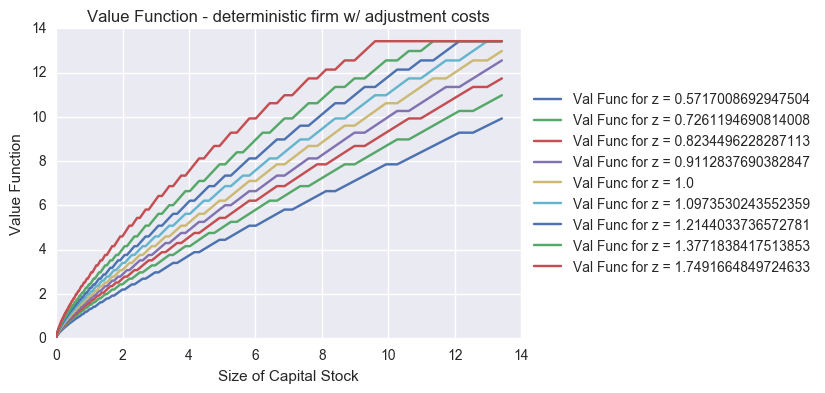

In [628]:
# plt.plot(kvec, VF[:, 0], label = 'k low')
# plt.plot(kvec, VF[:, sizez - 1], label = 'k high')
for i in range(sizez):
    plt.plot(kvec, optK[i,:], label = 'Val Func for z = {}'.format(z_grid[i]))
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Value Function - deterministic firm w/ adjustment costs')

# Exercise 2

In [635]:
dens = 5
# put in bounds here for the capital stock space
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (z ** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 5*kstar
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
for j in range(int(numb * dens)):
    K[j] = ub_k * (1 - delta) ** (j / dens)
kvec = K[::-1]
sizek = kvec.shape[0]

In [587]:
# operating profits, op
op = np.zeros((sizek, sizez))
for i in range(sizez):
    z = z_grid[i]
    op[:, i] = ((1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) *
      ((kvec ** alpha_k) ** (1 / (1 - alpha_l)))) * z ** (1/ (1 - alpha_l))

# firm cash flow, e
e = np.zeros((sizez, sizek, sizek))
for k in range(sizez):
    for i in range(sizek):
        for j in range(sizek):
            if i - j == dens:
                e[k, i, j] = op[i, k]  - kvec[j] + ((1 - delta) * kvec[i])
            else:
                e[k, i, j] = (op[i, k] - kvec[j] + ((1 - delta) * kvec[i]) - psi1 * kvec[i])

In [588]:
#notice that the cash flow with the dimension (z, k, k')
VFtol = 1e-6
VFdist = 7.0
VFmaxiter = 3000
V = np.zeros((sizek, sizez))  # initial guess at value function
Vmat = np.zeros((sizez, sizek, sizek))  # initialize Vmat matrix
Vstore = np.zeros((VFmaxiter, sizez, sizek))  # initialize Vstore array
VFiter = 1
start_time = time.clock()

def it_grid(sizez, sizek, Vmat, V, e):
    for k in range(sizez): #loope over different productivity
        for i in range(sizek):  # loop over k
            for j in range(sizek):  # loop over k'
                Vmat[k, i, j] = e[k, i, j] + betafirm * pi[k,:] @ V[j, :]
    return Vmat

it_grid_nb = jit(it_grid)
    
PF = np.zeros((sizez, sizek))
while VFdist > VFtol and VFiter < VFmaxiter:
    TV = V.copy()
#     for k in range(sizez): #loope over different productivity
#         for i in range(sizek):  # loop over k
#             for j in range(sizek):  # loop over k'
#                 Vmat[k, i, j] = e[k, i, j] + betafirm * pi[k,:] @ V[j, :]
    Vmat = it_grid_nb(sizez, sizek, Vmat, V, e)
    Vstore[VFiter, :, :] = V.T  # store value function at each
    # iteration for graphing later
    for k in range(sizez):
        V[:, k] = Vmat[k, :, :].max(axis=1)  # apply max operator to Vmat (to get V(k))
        PF[k, :] = np.argmax(Vmat[k, :, :], axis=1)  # find the index of the optimal k'
    VFdist = (np.absolute(V - TV)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    if VFiter % 10 == 0 or VFiter == 1:
        print(VFiter, VFdist)
    VFiter += 1

VFI_time = time.clock() - start_time
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')
print('VFI took ', VFI_time, ' seconds to solve')

1 57.0710496061
10 2.62895552843
20 1.51406120683
30 1.01460106403
40 0.685164784768
50 0.462864365653
60 0.312694311709
70 0.211245064201
80 0.142709595941
90 0.0964094895567
100 0.065130796679
110 0.0440000325234
120 0.0297248454
130 0.0200810404762
140 0.0135660314185
150 0.00916472473946
160 0.00619135965115
170 0.00418266073663
180 0.00282565572405
190 0.00190891176061
200 0.00128959238693
210 0.000871202409002
220 0.000588553131323
230 0.000397605406988
240 0.000268607966291
250 0.000181461917492
260 0.000122589169479
270 8.28168504086e-05
280 5.59480967013e-05
290 3.77965294547e-05
300 2.55339810167e-05
310 1.72498426707e-05
320 1.16533756369e-05
330 7.87260302104e-06
340 5.31844853668e-06
350 3.59295327712e-06
360 2.42727048771e-06
370 1.63977699685e-06
380 1.10777457962e-06
Value function converged after this many iterations: 384
VFI took  56.015934000000016  seconds to solve


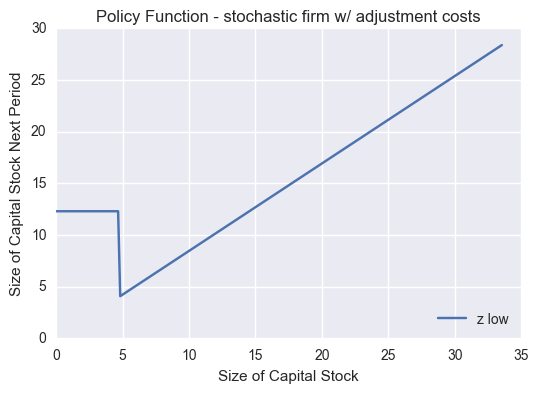

In [613]:
PF = PF.astype(int)
VF = V  # solution to the functional equation
'''
------------------------------------------------------------------------
Find optimal capital and investment policy functions
------------------------------------------------------------------------
optK = (sizek,) vector, optimal choice of k' for each k
optI = (sizek,) vector, optimal choice of investment for each k
------------------------------------------------------------------------
'''
optK = np.zeros((sizez, sizek))
optI = np.zeros((sizez, sizek))
for k in range(sizez):
    optK[k, :] = kvec[PF[k, :]]
    optI[k, :] = optK[k, :] - (1 - delta) * kvec
    
# plt.plot(kvec, VF[:, 0], label = 'k low')
# plt.plot(kvec, VF[:, sizez - 1], label = 'k high')
plt.plot(kvec, optK[4, :], label = 'z mid')
plt.xlabel('Size of Capital Stock')
plt.ylabel('Size of Capital Stock Next Period')
plt.legend(loc = 'lower right')
plt.title('Policy Function - stochastic firm w/ adjustment costs')

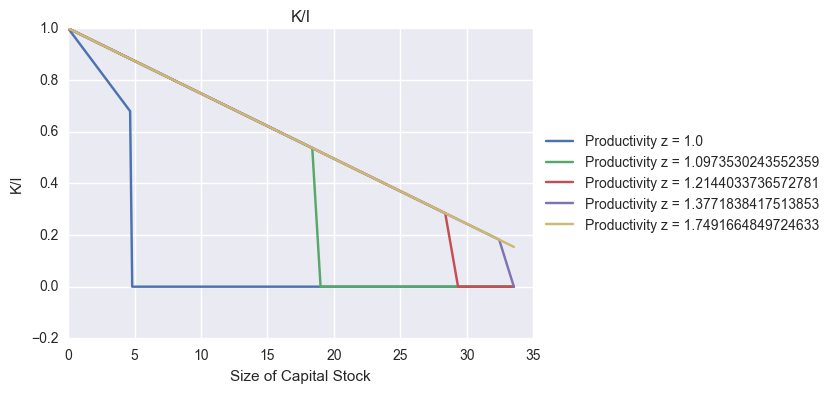

In [614]:
for i in range(sizez - 4):
    plt.plot(kvec, optI[i + 4, :] / optK[i + 4, :], label = 'Productivity z = {}'.format(z_grid[i + 4]))
plt.xlabel('Size of Capital Stock')
plt.ylabel('K/I')
plt.legend(loc = 'lower right')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('K/I')

The policy function stays at a plateau at first and then it drops and increase along the 1 - delta line. This is intuitive since it indicates that when the capital the firm owns is low, then the firm makes a one time purchase of capital; once the capital is higher than a threshold, the firm decides to not invest and let the capital depreciate.

# Exercise 3

In [616]:
#set up the parameters
sizez = 9
rho = 0.7605
mu = 0.0
sigma_eps = 0.213
sigma_z = sigma_eps / ((1 - rho ** 2) ** (1 / 2))
alpha_k = 0.297
alpha_l = 0.65
delta = 0.154
psi = 1.08
w = 0.7
r= 0.04
z = 1
psi1 = 0.03
betafirm = (1 / (1 + r))

# to print plots inline
%matplotlib inline


# Compute cut-off values
N = sizez  # number of grid points (will have one more cut-off point than this)
z_cutoffs = (sigma_z * norm.ppf(np.arange(N + 1) / N)) + mu
print('Cut-off values = ', z_cutoffs)
# compute grid points for z
z_grid = ((N * sigma_z * (norm.pdf((z_cutoffs[:-1] - mu) / sigma_z)
                              - norm.pdf((z_cutoffs[1:] - mu) / sigma_z)))
              + mu)
print('Grid points = ', z_grid)


# define function that we will integrate
def integrand(x, sigma_z, sigma_eps, rho, mu, z_j, z_jp1):
    val = (np.exp((-1 * ((x - mu) ** 2)) / (2 * (sigma_z ** 2)))
            * (norm.cdf((z_jp1 - (mu * (1 - rho)) - (rho * x)) / sigma_eps)
               - norm.cdf((z_j - (mu * (1 - rho)) - (rho * x)) / sigma_eps)))
    
    return val

# compute transition probabilities
pi = np.empty((N, N))
for i in range(N):
    for j in range(N):
        results = integrate.quad(integrand, z_cutoffs[i], z_cutoffs[i + 1],
                                 args = (sigma_z, sigma_eps, rho, mu,
                                         z_cutoffs[j], z_cutoffs[j + 1]))
        pi[i,j] = (N / np.sqrt(2 * np.pi * sigma_z ** 2)) * results[0]

Cut-off values =  [       -inf -0.40040229 -0.25084498 -0.14128994 -0.04582867  0.04582867
  0.14128994  0.25084498  0.40040229         inf]
Grid points =  [-0.55913938 -0.32004072 -0.19425291 -0.09290094  0.          0.09290094
  0.19425291  0.32004072  0.55913938]


In [617]:
dens = 5
z_grid = np.exp(z_grid)
# put in bounds here for the capital stock space
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (z ** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 2*kstar
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
for j in range(int(numb * dens)):
    K[j] = ub_k * (1 - delta) ** (j / dens)
kvec = K[::-1]
sizek = kvec.shape[0]

#operating marginal profit
pi_prime = np.zeros((sizez, sizek))
for i in range(sizez):
    z = z_grid[i]
    pi_prime[i, :] = alpha_k * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) *\
      ((kvec ** (alpha_k + alpha_l - 1))) ** (1 / (1 - alpha_l)) * z ** (1/ (1 - alpha_l))

In [618]:
#notice that the cash flow with the dimension (z, k, k')
Ctol = 1e-6
Cdist = 7.0
Cmaxiter = 3000
pol = np.zeros((sizez, sizek))  # initial guess at value function
for i in range(sizez):
    pol[i, :] = kvec.copy() * 0.1
error_mat = np.zeros((sizez, sizek, sizek))

Cstore = np.zeros((VFmaxiter, sizez, sizek))  # initialize Vstore array
Citer = 1
start_time = time.clock()

In [619]:
def it_pol_grid(sizez, sizek, kvec, Tpol, pi_prime, error_mat):
    for m in range(sizez): #loope over different productivity
        for i in range(sizek):  # loop over k
            for j in range(sizek):  # loop over k'
                k = kvec[i]
                k2 = kvec[j]
                k3 = Tpol[:, j]
                LHS = 1 + psi * ((k2 - (1 - delta) *k)/k)
                c2 = psi/2 * ((k3 - (1 - delta) * k2)/k2)**2 - psi * ((k3 - (1 - delta) * k2)/k2) * k3 / k2
                RHS = betafirm * (pi[m, :] @ pi_prime[:, j] + 1 - delta - pi[m, :] @ c2)
                error_mat[m, i, j] = abs(LHS - RHS)
    return error_mat

it_pol_grid_nb = jit(it_pol_grid)

PF = np.zeros((sizez, sizek))
while Cdist > Ctol and Citer < Cmaxiter:
    Tpol = pol.copy()
    error_mat = it_pol_grid_nb(sizez, sizek, kvec, Tpol, pi_prime, error_mat)
    Cstore[Citer, :, :] = pol  # store value function at each
    # iteration for graphing later
    for k in range(sizez):
        PF[k, :] = np.argmin(error_mat[k, :, :], axis=1)  # find the index of the optimal k'
        pol[k, :] = kvec[list(PF[k,:])]
    Cdist = (np.absolute(pol - Tpol)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    if Citer % 10 == 0 or Citer == 1:
        print(Citer, Cdist)
    Citer += 1

/Users/luxihan/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


1 10.7957461075
10 0.441395710804
20 0.226104684781


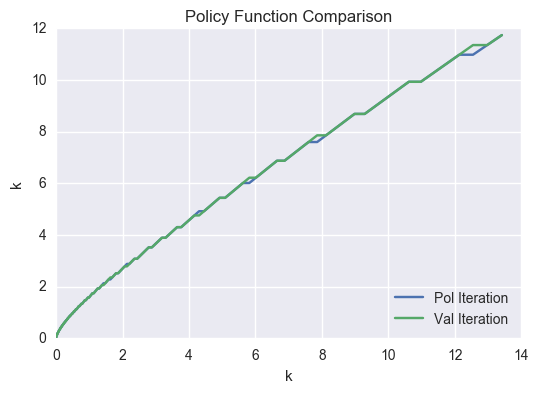

In [631]:
plt.plot(kvec, pol[2,:], label = 'Pol Iteration')
plt.plot(kvec, optK_copy[2,:], label = 'Val Iteration')
plt.xlabel('k')
plt.ylabel('k')
plt.title('Policy Function Comparison')
plt.legend(loc = 'lower right')

In [ ]:
plt.plot(kvec, pol[2,:], label = 'Pol Iteration')
plt.plot(kvec, optK_copy[2,:], label = 'Val Iteration')
plt.xlabel('k')
plt.ylabel('k')
plt.title('Policy Function Comparison')
plt.legend(loc = 'lower right')

# Exercise 4

In [645]:
#set up the parameters
sizez = 9
rho = 0.7605
mu = 0.0
sigma_eps = 0.213
sigma_z = sigma_eps / ((1 - rho ** 2) ** (1 / 2))
alpha_k = 0.297
alpha_l = 0.65
delta = 0.154
psi = 1.08
r= 0.04
z = 1
psi1 = 0.03
betafirm = (1 / (1 + r))
betafirm = 0.96
r = 1/betafirm - 1
h = 6.616

# to print plots inline
%matplotlib inline


# Compute cut-off values
N = sizez  # number of grid points (will have one more cut-off point than this)
z_cutoffs = (sigma_z * norm.ppf(np.arange(N + 1) / N)) + mu
print('Cut-off values = ', z_cutoffs)
# compute grid points for z
z_grid = ((N * sigma_z * (norm.pdf((z_cutoffs[:-1] - mu) / sigma_z)
                              - norm.pdf((z_cutoffs[1:] - mu) / sigma_z)))
              + mu)
z_grid = np.exp(z_grid)
print('Grid points = ', z_grid)


# define function that we will integrate
def integrand(x, sigma_z, sigma_eps, rho, mu, z_j, z_jp1):
    val = (np.exp((-1 * ((x - mu) ** 2)) / (2 * (sigma_z ** 2)))
            * (norm.cdf((z_jp1 - (mu * (1 - rho)) - (rho * x)) / sigma_eps)
               - norm.cdf((z_j - (mu * (1 - rho)) - (rho * x)) / sigma_eps)))
    
    return val

# compute transition probabilities
pi = np.empty((N, N))
for i in range(N):
    for j in range(N):
        results = integrate.quad(integrand, z_cutoffs[i], z_cutoffs[i + 1],
                                 args = (sigma_z, sigma_eps, rho, mu,
                                         z_cutoffs[j], z_cutoffs[j + 1]))
        pi[i,j] = (N / np.sqrt(2 * np.pi * sigma_z ** 2)) * results[0]
        
dens = 1
z_grid = np.exp(z_grid)
# put in bounds here for the capital stock space
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (z ** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 2*kstar
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
for j in range(int(numb * dens)):
    K[j] = ub_k * (1 - delta) ** (j / dens)
kvec = K[::-1]
sizek = kvec.shape[0]

Cut-off values =  [       -inf -0.40040229 -0.25084498 -0.14128994 -0.04582867  0.04582867
  0.14128994  0.25084498  0.40040229         inf]
Grid points =  [-0.55913938 -0.32004072 -0.19425291 -0.09290094  0.          0.09290094
  0.19425291  0.32004072  0.55913938]


In [646]:
def find_policy(w):
    print('w is{}'.format(w))
    # operating profits, op
    op = np.zeros((sizek, sizez))
    for i in range(sizez):
        z = z_grid[i]
        op[:, i] = ((1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) *
          ((kvec ** alpha_k) ** (1 / (1 - alpha_l)))) * z ** (1/ (1 - alpha_l))

    # firm cash flow, e
    e = np.zeros((sizez, sizek, sizek))
    for k in range(sizez):
        for i in range(sizek):
            for j in range(sizek):
                    e[k, i, j] = (op[i, k] - kvec[j] + ((1 - delta) * kvec[i]) -
                               ((psi / 2) * ((kvec[j] - ((1 - delta) * kvec[i])) ** 2)
                                / kvec[i]))
    #notice that the cash flow with the dimension (z, k, k')
    VFtol = 1e-6
    VFdist = 7.0
    VFmaxiter = 3000
    V = np.zeros((sizek, sizez))  # initial guess at value function
    Vmat = np.zeros((sizez, sizek, sizek))  # initialize Vmat matrix
    Vstore = np.zeros((VFmaxiter, sizez, sizek))  # initialize Vstore array
    VFiter = 1
    
    PF = np.zeros((sizez, sizek))
    while VFdist > VFtol and VFiter < VFmaxiter:
        TV = V.copy()
    #     for k in range(sizez): #loope over different productivity
    #         for i in range(sizek):  # loop over k
    #             for j in range(sizek):  # loop over k'
    #                 Vmat[k, i, j] = e[k, i, j] + betafirm * pi[k,:] @ V[j, :]
        Vmat = it_grid_nb(sizez, sizek, Vmat, V, e)
        Vstore[VFiter, :, :] = V.T  # store value function at each
        # iteration for graphing later
        for k in range(sizez):
            V[:, k] = Vmat[k, :, :].max(axis=1)  # apply max operator to Vmat (to get V(k))
            PF[k, :] = np.argmax(Vmat[k, :, :], axis=1)  # find the index of the optimal k'
        VFdist = (np.absolute(V - TV)).max()  # check distance between value
        # function for this iteration and value function from past iteration
        if VFiter % 100 == 0 or VFiter == 1:
            print(VFiter, VFdist)
        VFiter += 1
    PF = PF.astype(int)
    VF = V  # solution to the functional equation
    '''
    ------------------------------------------------------------------------
    Find optimal capital and investment policy functions
    ------------------------------------------------------------------------
    optK = (sizek,) vector, optimal choice of k' for each k
    optI = (sizek,) vector, optimal choice of investment for each k
    ------------------------------------------------------------------------
    '''
    optK = np.zeros((sizez, sizek))
    optI = np.zeros((sizez, sizek))
    for k in range(sizez):
        optK[k, :] = kvec[PF[k, :]]
    return VF, optK, PF

def find_distribution(PF, pi, z, kvec, sizez, sizek):
    Gamma = np.ones((sizez, sizek)) * (1 / (sizek * sizez))
    SDtol = 1e-12
    SDdist = 7
    SDiter = 0
    SDmaxiter = 1000
    while SDdist > SDtol and SDmaxiter > SDiter:
        HGamma = np.zeros((sizez, sizek))
        for i in range(sizez):  # z
            for j in range(sizek):  # k
                for m in range(sizez):  # z'
                    HGamma[m, PF[i, j]] = \
                        HGamma[m, PF[i, j]] + pi[i, m] * Gamma[i, j]
        SDdist = (np.absolute(HGamma - Gamma)).max()
        Gamma = HGamma
        SDiter += 1
    return Gamma

In [647]:
Tw = 10
w = 1.05
w_tol = 1e-5

def find_w(w, *args):
    kvec, z_grid = args
    VF, optK, PF = find_policy(w)
    Gamma = find_distribution(PF, pi, z_grid, kvec, sizez, sizek)
    K = kvec @ Gamma.sum(axis = 0)
    Z = z_grid @ Gamma.sum(axis = 1)
    l = np.zeros((sizez, sizek))
    for i in range(kvec.shape[0]):
        for j in range(z_grid.shape[0]):
            k = kvec[i]
            z = z_grid[j]
            l[j, i] = ((alpha_l * z * k **alpha_k) / w)**(1/(1 - alpha_l))
    L = (l * Gamma).sum()
    error = L**2 * h - 1
    return error**2

find_w_nb = jit(find_w)
while abs(Tw - w) > w_tol:
    Tw = w
#     w = opt.fminbound(find_w, 1e-10, 100, args = (Gamma, kvec, z_grid))
#     w = opt.fsolve(find_w_nb, x0 = Tw, args=(kvec, z_grid))
    w = opt.fminbound(find_w_nb, 1e-10, 5, args = (kvec, z_grid))

w is1.909830056312329
1 7.84429990059
w is3.0901699437876706
1 6.65256079745
100 1.91624682966e-06
w is1.1803398875753417
1 10.757035695
100 0.000206095034279
200 4.0806831052e-06
w is0.7294901688369875
1 17.8760685317
100 0.0245239154594
200 0.00048557450986
300 9.61439478431e-06
w is1.458980337573975
1 9.15304195214
100 1.58007700293e-05
w is1.0081306188356207
1 12.4345309822
100 0.00142528561195
200 2.8220684742e-05
w is1.286771068834254
1 10.0267440564
100 7.17245835524e-05
200 1.42014655502e-06
w is1.114561800094533
1 11.3109759508
100 0.000416113375575
200 8.2390506293e-06
w is1.0739087063164294
1 11.7027349171
100 0.000656515214899
200 1.29990106075e-05
w is1.0487837126137245
1 11.9668147743
100 0.000877862870066
200 1.73816989921e-05
w is1.0332556125383257
1 12.1392694335
100 0.00105399266332
200 2.08690734809e-05
w is1.0574077454805624
1 11.874147835
100 0.000793509194736
200 1.57114946333e-05
w is1.0530914961182951
1 11.9202557634
100 0.00083442433785
200 1.65216180612e-05
w 

w is1.0534035351403581
1 11.9169043259
100 0.000831296959344
200 1.64596958214e-05


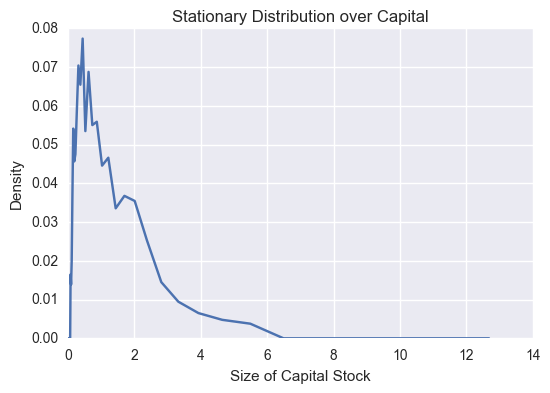

In [648]:
VF, optK, PF = find_policy(w)
Gamma = find_distribution(PF, pi, z_grid, kvec, sizez, sizek)

fig, ax = plt.subplots()
ax.plot(kvec, Gamma.sum(axis=0))
plt.xlabel('Size of Capital Stock')
plt.ylabel('Density')
plt.title('Stationary Distribution over Capital')


In [649]:
r = 1/betafirm - 1
print('r is {}'.format(r))
print('w is {}'.format(Tw))

r is 0.04166666666666674
w is 1.0534035351403581
